In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pickle
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [4]:
# dataDic["train"].columns

In [5]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [6]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [7]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
embeddings_dim = [50, 50, 50, 50, 50, 50, 570]
dropout = 0.1
one_cycle = True
lr = 3e-5
epochs = 20
clip = 5


In [8]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [9]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [10]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [11]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [12]:
# actual path
original_path = os.getcwd()
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [13]:
import utilities
import models

In [14]:
# Importing the list of unique categories for the categorical features
with open(f"data/processed_dataFrames/list_cat.pickle", "rb") as f:
    list_cat = pickle.load(f)

In [15]:
# Setting up the loaders
dfs=utilities.load_dataFrames()
train_loader=utilities.create_dataLoader(X_time=dfs["X_time_train"],
                                         X_static=dfs["X_tabular_train"],
                                         X_static_cat=dfs["X_tabular_cat_train"],
                                         y_target=dfs["y_target_train"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=True
                                         )
valid_loader=utilities.create_dataLoader(X_time=dfs["X_time_valid"],
                                         X_static=dfs["X_tabular_valid"],
                                         X_static_cat=dfs["X_tabular_cat_valid"],
                                         y_target=dfs["y_target_valid"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=False
                                         )
test_loader=utilities.create_dataLoader(X_time=dfs["X_time_test"],
                                        X_static=dfs["X_tabular_test"],
                                        X_static_cat=dfs["X_tabular_cat_test"],
                                        y_target=dfs["y_target_test"],
                                        output_weeks=output_weeks,
                                        y_past=None,
                                        batch_size=128,
                                        shuffle=False
                                        )


In [16]:
os.chdir(original_path)

In [17]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        list_unic_cat,
        embedding_dims,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )

        self.after_embeddings = nn.Sequential(
            nn.Linear(int(sum(embedding_dims)), 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 16)
        )

        tabular_total_size = num_numerical_features + 16
        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(tabular_total_size, tabular_total_size))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(tabular_total_size, tabular_total_size)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = tabular_total_size + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, categorical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)

        time_series_data = time_series_data.to(torch.float32)
        numerical_data = numerical_data.to(torch.float32)
        categorical_data = categorical_data.to(torch.int64)

        embeddings = [emb(categorical_data[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        x_cat = self.after_embeddings(x_cat)
        x_tabular = torch.cat((x_cat, numerical_data), dim=1)
        x1 = self.tabular_fc_layers(x_tabular)

        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        lstm_out = self.layer_norm(lstm_out) # Apply layer normalization
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output

        # Combined MLPs and output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [18]:
writer = SummaryWriter('../runs/add_embeddings')

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=dfs["X_tabular_train"].shape[-1],
    num_time_series_features=dfs["X_time_train"].shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.HuberLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, static_cat, labels) in tqdm(enumerate(train_loader),
                                                       desc=f"epoch {i+1}/{epochs}",
                                                       total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static, static_cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            static_cat.to(device),
        )
        
        model.zero_grad()
        output = model(inputs, static, static_cat)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, stat_cat, lab in valid_loader:
                    inp, lab, stat, stat_cat = inp.to(device), lab.to(device), stat.to(device), stat_cat.to(device)
                    out = model(inp, stat, stat_cat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(Hubber)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/add_embeddings.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/20:  50%|█████     | 404/808 [02:32<27:18,  4.06s/it]

{'loss': 0.4158152937889099, 'epoch': 0.5, 'step': 404, 'lr': 1.6908694266189075e-06, 'week': 1, 'validation_loss': np.float64(0.32235398748214694), 'macro_f1': np.float64(0.17353293724393423), 'micro_f1': np.float64(0.6386602652034751), 'mae': np.float64(0.6602527151654415)}
{'loss': 0.4158152937889099, 'epoch': 0.5, 'step': 404, 'lr': 1.6908694266189075e-06, 'week': 2, 'validation_loss': np.float64(0.32235398748214694), 'macro_f1': np.float64(0.13275553721282157), 'micro_f1': np.float64(0.6618655692729767), 'mae': np.float64(0.6410693902309664)}
{'loss': 0.4158152937889099, 'epoch': 0.5, 'step': 404, 'lr': 1.6908694266189075e-06, 'week': 3, 'validation_loss': np.float64(0.32235398748214694), 'macro_f1': np.float64(0.14944701736859536), 'micro_f1': np.float64(0.6464334705075446), 'mae': np.float64(0.6687853241375106)}
{'loss': 0.4158152937889099, 'epoch': 0.5, 'step': 404, 'lr': 1.6908694266189075e-06, 'week': 4, 'validation_loss': np.float64(0.32235398748214694), 'macro_f1': np.float

epoch 1/20: 100%|██████████| 808/808 [05:05<00:00,  2.64it/s]


{'loss': 0.3237968385219574, 'epoch': 1.0, 'step': 808, 'lr': 3.1300120406438104e-06, 'week': 1, 'validation_loss': np.float64(0.2611256872938163), 'macro_f1': np.float64(0.2295071670322216), 'micro_f1': np.float64(0.5879058070416096), 'mae': np.float64(0.5085756236588084)}
{'loss': 0.3237968385219574, 'epoch': 1.0, 'step': 808, 'lr': 3.1300120406438104e-06, 'week': 2, 'validation_loss': np.float64(0.2611256872938163), 'macro_f1': np.float64(0.21036993392662828), 'micro_f1': np.float64(0.5692729766803841), 'mae': np.float64(0.5505599412101122)}
{'loss': 0.3237968385219574, 'epoch': 1.0, 'step': 808, 'lr': 3.1300120406438104e-06, 'week': 3, 'validation_loss': np.float64(0.2611256872938163), 'macro_f1': np.float64(0.21499466806528314), 'micro_f1': np.float64(0.5772748056698674), 'mae': np.float64(0.5467278340628705)}
{'loss': 0.3237968385219574, 'epoch': 1.0, 'step': 808, 'lr': 3.1300120406438104e-06, 'week': 4, 'validation_loss': np.float64(0.2611256872938163), 'macro_f1': np.float64(0.

epoch 2/20:  50%|█████     | 404/808 [02:32<27:16,  4.05s/it]

{'loss': 0.23751288652420044, 'epoch': 1.5, 'step': 1212, 'lr': 5.419312410162312e-06, 'week': 1, 'validation_loss': np.float64(0.22975015467491702), 'macro_f1': np.float64(0.32047969896726386), 'micro_f1': np.float64(0.6767261088248743), 'mae': np.float64(0.44464907766129064)}
{'loss': 0.23751288652420044, 'epoch': 1.5, 'step': 1212, 'lr': 5.419312410162312e-06, 'week': 2, 'validation_loss': np.float64(0.22975015467491702), 'macro_f1': np.float64(0.31145083371591986), 'micro_f1': np.float64(0.6583219021490626), 'mae': np.float64(0.46823891204812973)}
{'loss': 0.23751288652420044, 'epoch': 1.5, 'step': 1212, 'lr': 5.419312410162312e-06, 'week': 3, 'validation_loss': np.float64(0.22975015467491702), 'macro_f1': np.float64(0.2969785163669358), 'micro_f1': np.float64(0.6556927297668038), 'mae': np.float64(0.4913992264787545)}
{'loss': 0.23751288652420044, 'epoch': 1.5, 'step': 1212, 'lr': 5.419312410162312e-06, 'week': 4, 'validation_loss': np.float64(0.22975015467491702), 'macro_f1': np.

epoch 2/20: 100%|██████████| 808/808 [05:05<00:00,  2.65it/s]


{'loss': 0.2040552943944931, 'epoch': 2.0, 'step': 1616, 'lr': 8.40269448520996e-06, 'week': 1, 'validation_loss': np.float64(0.2243558513675479), 'macro_f1': np.float64(0.34284135091906925), 'micro_f1': np.float64(0.6633516232281664), 'mae': np.float64(0.43746669629621787)}
{'loss': 0.2040552943944931, 'epoch': 2.0, 'step': 1616, 'lr': 8.40269448520996e-06, 'week': 2, 'validation_loss': np.float64(0.2243558513675479), 'macro_f1': np.float64(0.32791591945837184), 'micro_f1': np.float64(0.6474622770919067), 'mae': np.float64(0.4663511194889859)}
{'loss': 0.2040552943944931, 'epoch': 2.0, 'step': 1616, 'lr': 8.40269448520996e-06, 'week': 3, 'validation_loss': np.float64(0.2243558513675479), 'macro_f1': np.float64(0.3084033055964481), 'micro_f1': np.float64(0.6336305441243713), 'mae': np.float64(0.4915055340439367)}
{'loss': 0.2040552943944931, 'epoch': 2.0, 'step': 1616, 'lr': 8.40269448520996e-06, 'week': 4, 'validation_loss': np.float64(0.2243558513675479), 'macro_f1': np.float64(0.302

epoch 3/20:  50%|█████     | 404/808 [02:32<27:15,  4.05s/it]

{'loss': 0.22910481691360474, 'epoch': 2.5, 'step': 2020, 'lr': 1.187676228681957e-05, 'week': 1, 'validation_loss': np.float64(0.21735502452846023), 'macro_f1': np.float64(0.3860031725530983), 'micro_f1': np.float64(0.6812985825331505), 'mae': np.float64(0.41076676598172734)}
{'loss': 0.22910481691360474, 'epoch': 2.5, 'step': 2020, 'lr': 1.187676228681957e-05, 'week': 2, 'validation_loss': np.float64(0.21735502452846023), 'macro_f1': np.float64(0.34855063973822803), 'micro_f1': np.float64(0.6657521719250115), 'mae': np.float64(0.4394466293918749)}
{'loss': 0.22910481691360474, 'epoch': 2.5, 'step': 2020, 'lr': 1.187676228681957e-05, 'week': 3, 'validation_loss': np.float64(0.21735502452846023), 'macro_f1': np.float64(0.32529125812233145), 'micro_f1': np.float64(0.6504343850022862), 'mae': np.float64(0.4702178729550302)}
{'loss': 0.22910481691360474, 'epoch': 2.5, 'step': 2020, 'lr': 1.187676228681957e-05, 'week': 4, 'validation_loss': np.float64(0.21735502452846023), 'macro_f1': np.f

epoch 3/20: 100%|██████████| 808/808 [05:04<00:00,  2.65it/s]


{'loss': 0.2080828696489334, 'epoch': 3.0, 'step': 2424, 'lr': 1.5604666694184012e-05, 'week': 1, 'validation_loss': np.float64(0.2139756686553575), 'macro_f1': np.float64(0.4377955666843543), 'micro_f1': np.float64(0.6899862825788752), 'mae': np.float64(0.3936759955255499)}
{'loss': 0.2080828696489334, 'epoch': 3.0, 'step': 2424, 'lr': 1.5604666694184012e-05, 'week': 2, 'validation_loss': np.float64(0.2139756686553575), 'macro_f1': np.float64(0.4259395440356319), 'micro_f1': np.float64(0.67466849565615), 'mae': np.float64(0.4247944936760435)}
{'loss': 0.2080828696489334, 'epoch': 3.0, 'step': 2424, 'lr': 1.5604666694184012e-05, 'week': 3, 'validation_loss': np.float64(0.2139756686553575), 'macro_f1': np.float64(0.40236966362762977), 'micro_f1': np.float64(0.661408321902149), 'mae': np.float64(0.45206711001766786)}
{'loss': 0.2080828696489334, 'epoch': 3.0, 'step': 2424, 'lr': 1.5604666694184012e-05, 'week': 4, 'validation_loss': np.float64(0.2139756686553575), 'macro_f1': np.float64(0

epoch 4/20:  50%|█████     | 404/808 [02:32<27:23,  4.07s/it]

{'loss': 0.20147967338562012, 'epoch': 3.5, 'step': 2828, 'lr': 1.9332252943562577e-05, 'week': 1, 'validation_loss': np.float64(0.19896300706634487), 'macro_f1': np.float64(0.455823387557823), 'micro_f1': np.float64(0.7007315957933242), 'mae': np.float64(0.3736686968806624)}
{'loss': 0.20147967338562012, 'epoch': 3.5, 'step': 2828, 'lr': 1.9332252943562577e-05, 'week': 2, 'validation_loss': np.float64(0.19896300706634487), 'macro_f1': np.float64(0.4338130252904051), 'micro_f1': np.float64(0.6873571101966164), 'mae': np.float64(0.40118950898448785)}
{'loss': 0.20147967338562012, 'epoch': 3.5, 'step': 2828, 'lr': 1.9332252943562577e-05, 'week': 3, 'validation_loss': np.float64(0.19896300706634487), 'macro_f1': np.float64(0.41200010316767816), 'micro_f1': np.float64(0.6742112482853223), 'mae': np.float64(0.4251362411174369)}
{'loss': 0.20147967338562012, 'epoch': 3.5, 'step': 2828, 'lr': 1.9332252943562577e-05, 'week': 4, 'validation_loss': np.float64(0.19896300706634487), 'macro_f1': np

epoch 4/20: 100%|██████████| 808/808 [05:04<00:00,  2.65it/s]


{'loss': 0.16190633177757263, 'epoch': 4.0, 'step': 3232, 'lr': 2.2805387962051793e-05, 'week': 1, 'validation_loss': np.float64(0.18676523170501425), 'macro_f1': np.float64(0.5154596582839591), 'micro_f1': np.float64(0.7097622313671696), 'mae': np.float64(0.3631360206599289)}
{'loss': 0.16190633177757263, 'epoch': 4.0, 'step': 3232, 'lr': 2.2805387962051793e-05, 'week': 2, 'validation_loss': np.float64(0.18676523170501425), 'macro_f1': np.float64(0.48739852426598285), 'micro_f1': np.float64(0.6910150891632373), 'mae': np.float64(0.39665132504767525)}
{'loss': 0.16190633177757263, 'epoch': 4.0, 'step': 3232, 'lr': 2.2805387962051793e-05, 'week': 3, 'validation_loss': np.float64(0.18676523170501425), 'macro_f1': np.float64(0.4452852924331447), 'micro_f1': np.float64(0.6721536351165981), 'mae': np.float64(0.42393581212368875)}
{'loss': 0.16190633177757263, 'epoch': 4.0, 'step': 3232, 'lr': 2.2805387962051793e-05, 'week': 4, 'validation_loss': np.float64(0.18676523170501425), 'macro_f1': 

epoch 5/20:  50%|█████     | 404/808 [02:32<27:28,  4.08s/it]

{'loss': 0.1695500910282135, 'epoch': 4.5, 'step': 3636, 'lr': 2.578728622255501e-05, 'week': 1, 'validation_loss': np.float64(0.16434504496662514), 'macro_f1': np.float64(0.43156490797003205), 'micro_f1': np.float64(0.7459990855052584), 'mae': np.float64(0.31677541193370556)}
{'loss': 0.1695500910282135, 'epoch': 4.5, 'step': 3636, 'lr': 2.578728622255501e-05, 'week': 2, 'validation_loss': np.float64(0.16434504496662514), 'macro_f1': np.float64(0.39802487716848733), 'micro_f1': np.float64(0.7238225880201189), 'mae': np.float64(0.3480148862374309)}
{'loss': 0.1695500910282135, 'epoch': 4.5, 'step': 3636, 'lr': 2.578728622255501e-05, 'week': 3, 'validation_loss': np.float64(0.16434504496662514), 'macro_f1': np.float64(0.37649552855653107), 'micro_f1': np.float64(0.7049611339734797), 'mae': np.float64(0.379376327823669)}
{'loss': 0.1695500910282135, 'epoch': 4.5, 'step': 3636, 'lr': 2.578728622255501e-05, 'week': 4, 'validation_loss': np.float64(0.16434504496662514), 'macro_f1': np.float

epoch 5/20: 100%|██████████| 808/808 [05:05<00:00,  2.65it/s]


{'loss': 0.18549787998199463, 'epoch': 5.0, 'step': 4040, 'lr': 2.8074652907104303e-05, 'week': 1, 'validation_loss': np.float64(0.15703959468806136), 'macro_f1': np.float64(0.5954944231172677), 'micro_f1': np.float64(0.7605166895290352), 'mae': np.float64(0.3102863663562867)}
{'loss': 0.18549787998199463, 'epoch': 5.0, 'step': 4040, 'lr': 2.8074652907104303e-05, 'week': 2, 'validation_loss': np.float64(0.15703959468806136), 'macro_f1': np.float64(0.5588524007293222), 'micro_f1': np.float64(0.736854138088706), 'mae': np.float64(0.33908702453416173)}
{'loss': 0.18549787998199463, 'epoch': 5.0, 'step': 4040, 'lr': 2.8074652907104303e-05, 'week': 3, 'validation_loss': np.float64(0.15703959468806136), 'macro_f1': np.float64(0.5328221114326754), 'micro_f1': np.float64(0.7109053497942387), 'mae': np.float64(0.37423035719699876)}
{'loss': 0.18549787998199463, 'epoch': 5.0, 'step': 4040, 'lr': 2.8074652907104303e-05, 'week': 4, 'validation_loss': np.float64(0.15703959468806136), 'macro_f1': np

epoch 6/20:  50%|█████     | 404/808 [02:32<27:06,  4.03s/it]

{'loss': 0.13434578478336334, 'epoch': 5.5, 'step': 4444, 'lr': 2.9511543797239673e-05, 'week': 1, 'validation_loss': np.float64(0.12560367535637773), 'macro_f1': np.float64(0.5997132512837173), 'micro_f1': np.float64(0.8204160951074532), 'mae': np.float64(0.22403079420856087)}
{'loss': 0.13434578478336334, 'epoch': 5.5, 'step': 4444, 'lr': 2.9511543797239673e-05, 'week': 2, 'validation_loss': np.float64(0.12560367535637773), 'macro_f1': np.float64(0.5336856691783672), 'micro_f1': np.float64(0.78360768175583), 'mae': np.float64(0.26503856428725553)}
{'loss': 0.13434578478336334, 'epoch': 5.5, 'step': 4444, 'lr': 2.9511543797239673e-05, 'week': 3, 'validation_loss': np.float64(0.12560367535637773), 'macro_f1': np.float64(0.4958436500230634), 'micro_f1': np.float64(0.7527434842249657), 'mae': np.float64(0.30311071363490044)}
{'loss': 0.13434578478336334, 'epoch': 5.5, 'step': 4444, 'lr': 2.9511543797239673e-05, 'week': 4, 'validation_loss': np.float64(0.12560367535637773), 'macro_f1': np

epoch 6/20: 100%|██████████| 808/808 [05:04<00:00,  2.65it/s]


{'loss': 0.14491917192935944, 'epoch': 6.0, 'step': 4848, 'lr': 2.9999999421530488e-05, 'week': 1, 'validation_loss': np.float64(0.11468489954005116), 'macro_f1': np.float64(0.6848116416830607), 'micro_f1': np.float64(0.8423639689071788), 'mae': np.float64(0.1947416638576675)}
{'loss': 0.14491917192935944, 'epoch': 6.0, 'step': 4848, 'lr': 2.9999999421530488e-05, 'week': 2, 'validation_loss': np.float64(0.11468489954005116), 'macro_f1': np.float64(0.6151032463171634), 'micro_f1': np.float64(0.7997256515775034), 'mae': np.float64(0.24778294959067707)}
{'loss': 0.14491917192935944, 'epoch': 6.0, 'step': 4848, 'lr': 2.9999999421530488e-05, 'week': 3, 'validation_loss': np.float64(0.11468489954005116), 'macro_f1': np.float64(0.5733269637070052), 'micro_f1': np.float64(0.7621170553269319), 'mae': np.float64(0.2965691592213231)}
{'loss': 0.14491917192935944, 'epoch': 6.0, 'step': 4848, 'lr': 2.9999999421530488e-05, 'week': 4, 'validation_loss': np.float64(0.11468489954005116), 'macro_f1': np

epoch 7/20:  50%|█████     | 404/808 [02:32<27:14,  4.05s/it]

{'loss': 0.11059137433767319, 'epoch': 6.5, 'step': 5252, 'lr': 2.990521652752573e-05, 'week': 1, 'validation_loss': np.float64(0.11175526033385076), 'macro_f1': np.float64(0.6863114465942113), 'micro_f1': np.float64(0.8558527663465935), 'mae': np.float64(0.1816918268358397)}
{'loss': 0.11059137433767319, 'epoch': 6.5, 'step': 5252, 'lr': 2.990521652752573e-05, 'week': 2, 'validation_loss': np.float64(0.11175526033385076), 'macro_f1': np.float64(0.6435293330377754), 'micro_f1': np.float64(0.8124142661179699), 'mae': np.float64(0.23468658499263992)}
{'loss': 0.11059137433767319, 'epoch': 6.5, 'step': 5252, 'lr': 2.990521652752573e-05, 'week': 3, 'validation_loss': np.float64(0.11175526033385076), 'macro_f1': np.float64(0.6014892820350763), 'micro_f1': np.float64(0.7746913580246914), 'mae': np.float64(0.285259968261131)}
{'loss': 0.11059137433767319, 'epoch': 6.5, 'step': 5252, 'lr': 2.990521652752573e-05, 'week': 4, 'validation_loss': np.float64(0.11175526033385076), 'macro_f1': np.floa

epoch 7/20: 100%|██████████| 808/808 [05:04<00:00,  2.65it/s]


{'loss': 0.16503572463989258, 'epoch': 7.0, 'step': 5656, 'lr': 2.9622992642014076e-05, 'week': 1, 'validation_loss': np.float64(0.11197351437547932), 'macro_f1': np.float64(0.7115666357885134), 'micro_f1': np.float64(0.8579103795153178), 'mae': np.float64(0.17939265829635187)}
{'loss': 0.16503572463989258, 'epoch': 7.0, 'step': 5656, 'lr': 2.9622992642014076e-05, 'week': 2, 'validation_loss': np.float64(0.11197351437547932), 'macro_f1': np.float64(0.655019847411776), 'micro_f1': np.float64(0.8111568358481939), 'mae': np.float64(0.23370168870728075)}
{'loss': 0.16503572463989258, 'epoch': 7.0, 'step': 5656, 'lr': 2.9622992642014076e-05, 'week': 3, 'validation_loss': np.float64(0.11197351437547932), 'macro_f1': np.float64(0.6264561299519268), 'micro_f1': np.float64(0.7744627343392776), 'mae': np.float64(0.2813461220449797)}
{'loss': 0.16503572463989258, 'epoch': 7.0, 'step': 5656, 'lr': 2.9622992642014076e-05, 'week': 4, 'validation_loss': np.float64(0.11197351437547932), 'macro_f1': np

epoch 8/20:  50%|█████     | 404/808 [02:32<27:14,  4.05s/it]

{'loss': 0.1126842349767685, 'epoch': 7.5, 'step': 6060, 'lr': 2.9156876894105953e-05, 'week': 1, 'validation_loss': np.float64(0.10445962068827255), 'macro_f1': np.float64(0.7614228394855206), 'micro_f1': np.float64(0.8762002743484225), 'mae': np.float64(0.15463226410959652)}
{'loss': 0.1126842349767685, 'epoch': 7.5, 'step': 6060, 'lr': 2.9156876894105953e-05, 'week': 2, 'validation_loss': np.float64(0.10445962068827255), 'macro_f1': np.float64(0.6905442936776233), 'micro_f1': np.float64(0.8251028806584362), 'mae': np.float64(0.2124692484887047)}
{'loss': 0.1126842349767685, 'epoch': 7.5, 'step': 6060, 'lr': 2.9156876894105953e-05, 'week': 3, 'validation_loss': np.float64(0.10445962068827255), 'macro_f1': np.float64(0.6369976348306091), 'micro_f1': np.float64(0.785893918609968), 'mae': np.float64(0.2662043438360278)}
{'loss': 0.1126842349767685, 'epoch': 7.5, 'step': 6060, 'lr': 2.9156876894105953e-05, 'week': 4, 'validation_loss': np.float64(0.10445962068827255), 'macro_f1': np.floa

epoch 8/20: 100%|██████████| 808/808 [05:04<00:00,  2.65it/s]


{'loss': 0.099014051258564, 'epoch': 8.0, 'step': 6464, 'lr': 2.8512730959777957e-05, 'week': 1, 'validation_loss': np.float64(0.10549261456058509), 'macro_f1': np.float64(0.7585930430923543), 'micro_f1': np.float64(0.8741426611796982), 'mae': np.float64(0.15254303091010532)}
{'loss': 0.099014051258564, 'epoch': 8.0, 'step': 6464, 'lr': 2.8512730959777957e-05, 'week': 2, 'validation_loss': np.float64(0.10549261456058509), 'macro_f1': np.float64(0.6810478524157239), 'micro_f1': np.float64(0.8238454503886603), 'mae': np.float64(0.20589109958599155)}
{'loss': 0.099014051258564, 'epoch': 8.0, 'step': 6464, 'lr': 2.8512730959777957e-05, 'week': 3, 'validation_loss': np.float64(0.10549261456058509), 'macro_f1': np.float64(0.6291685778204261), 'micro_f1': np.float64(0.7837219935985368), 'mae': np.float64(0.25367490112918195)}
{'loss': 0.099014051258564, 'epoch': 8.0, 'step': 6464, 'lr': 2.8512730959777957e-05, 'week': 4, 'validation_loss': np.float64(0.10549261456058509), 'macro_f1': np.float

epoch 9/20:  27%|██▋       | 217/808 [01:15<03:26,  2.87it/s]

In [23]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=dfs["X_tabular_train"].shape[-1],
    num_time_series_features=dfs["X_time_train"].shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/new_attention.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
  (lstm): LSTM(21, 512, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=542, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [24]:
def predict(x, static, static_cat):
    out = model(torch.tensor(x), static, static_cat)
    return out

In [25]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, static_cat, y in tqdm(
    valid_loader,# ou test_loader
    desc="validation predictions...",
    ):
    x, static, static_cat, y = x.to(device), static.to(device), static_cat.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_1427511/4252433048.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static)
validation predictions...: 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


In [26]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
Week 1 MAE 0.147 F1 0.757
Week 2 MAE 0.203 F1 0.704
Week 3 MAE 0.256 F1 0.643
Week 4 MAE 0.307 F1 0.569
Week 5 MAE 0.355 F1 0.54
Week 6 MAE 0.396 F1 0.484
"""

Week 1 MAE 0.138 F1 0.781
Week 2 MAE 0.198 F1 0.702
Week 3 MAE 0.253 F1 0.644
Week 4 MAE 0.305 F1 0.566
Week 5 MAE 0.352 F1 0.515
Week 6 MAE 0.391 F1 0.474


'\nWeek 1 MAE 0.147 F1 0.757\nWeek 2 MAE 0.203 F1 0.704\nWeek 3 MAE 0.256 F1 0.643\nWeek 4 MAE 0.307 F1 0.569\nWeek 5 MAE 0.355 F1 0.54\nWeek 6 MAE 0.396 F1 0.484\n'

In [27]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.007185,0,0.0000,0
1,0.032780,0,0.0000,0
2,0.005626,0,0.0000,0
3,0.002370,0,0.0000,0
4,0.873590,1,0.7767,0
...,...,...,...,...
52483,0.223612,0,0.9964,5
52484,1.020118,1,1.9211,5
52485,0.282991,0,0.0000,5
52486,0.138431,0,0.0000,5


In [28]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.9201662605704457
Accuracy 1:
0.5136957437842393
Accuracy 2:
0.4978822532825074
Accuracy 3:
0.5393548387096774
Accuracy 5:
0.4307692307692308
Accuracy 4:
0.6098964326812428


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
# do a table using print in the terminal
print("  MAE  | RMSE  |  F1  ")
print(f"{mae} | {rmse} | {f1}")

(array([5.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        2.0000e+00, 4.0000e+00, 2.3000e+01, 1.5000e+01, 2.6000e+01,
        3.5000e+01, 7.0000e+01, 1.0500e+02, 1.3600e+02, 1.3200e+02,
        2.1100e+02, 3.9200e+02, 5.7200e+02, 7.4800e+02, 1.0910e+03,
        2.2630e+03, 6.6290e+03, 2.6921e+04, 3.2980e+03, 2.1950e+03,
        1.8030e+03, 1.7270e+03, 1.7400e+03, 9.9300e+02, 4.4600e+02,
        2.7300e+02, 2.1900e+02, 1.9600e+02, 1.1100e+02, 3.4000e+01,
        2.6000e+01, 1.6000e+01, 1.6000e+01, 8.0000e+00, 3.0000e+00]),
 array([-3.97752953, -3.80387531, -3.6302211 , -3.45656688, -3.28291266,
        -3.10925845, -2.93560423, -2.76195002, -2.5882958 , -2.41464159,
        -2.24098737, -2.06733316, -1.89367894, -1.72002473, -1.54637051,
        -1.3727163 , -1.19906208, -1.02540787, -0.85175365, -0.67809944,
        -0.50444522, -0.330791  , -0.15713679,  0.01651743,  0.19017164,
         0.36382586,  0.53748007,  0.71113429,  0.8847885 ,  1.05844272,
         1.23209

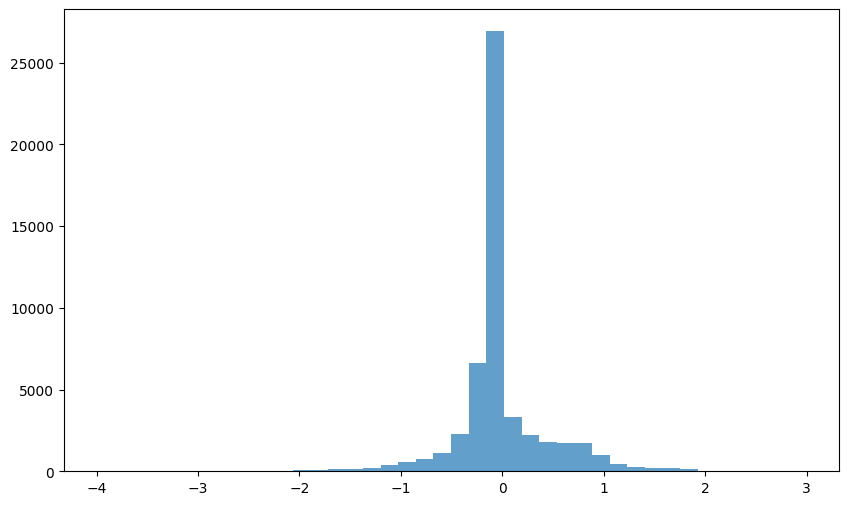

In [29]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

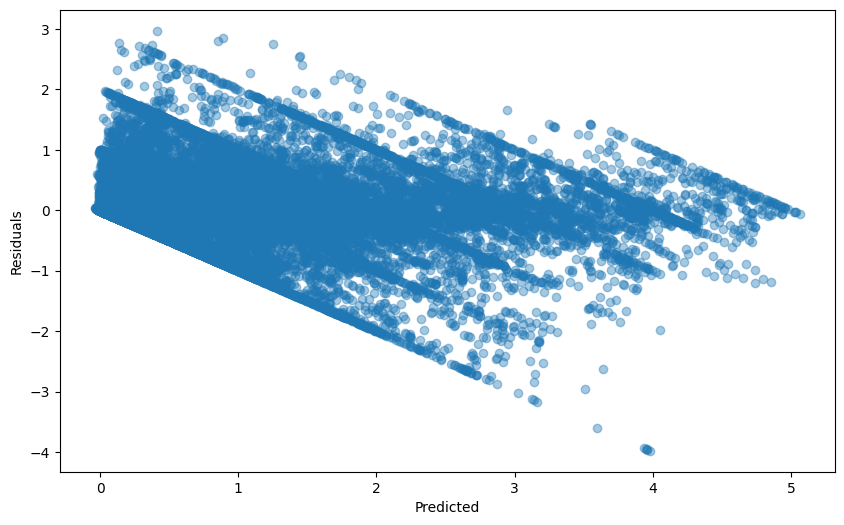

In [30]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

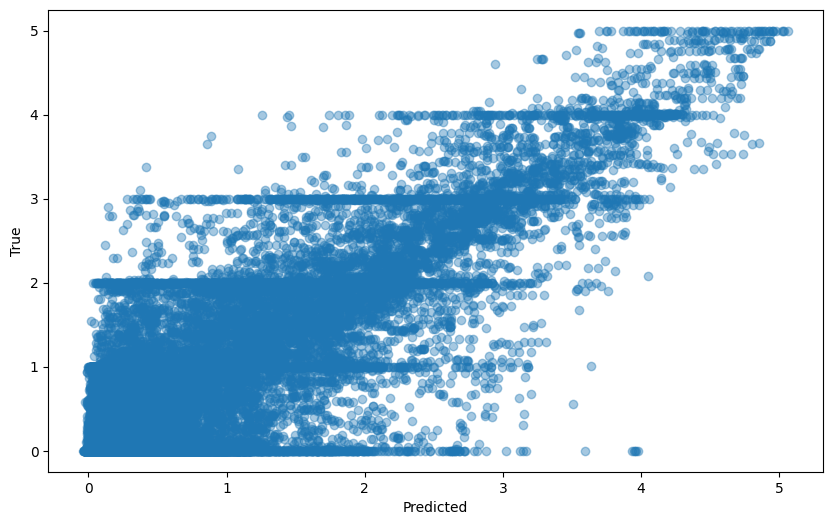

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")